In [60]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from em import generate_data, run_gmm

In [61]:
"""
1. Generate synthetic data from a 3-mode gaussian mixture model
"""

x = generate_data(10000, mode_means=np.array([0, 5, 10]), mode_variances=np.array([1, 1, 1]), weights=np.array([0.2, 0.5, 0.3]))
x1 = generate_data(10000, num_modes=1)
x2 = generate_data(10000, num_modes=2)
x3 = generate_data(10000, num_modes=3)

Means = 0, 5, 10, Vars = 1, 1, 1, Weights = 0.2, 0.5, 0.3
Means = 91, Vars = 5, Weights = 1.0
Means = 54, 63, Vars = 4, 1, Weights = 0.78, 0.22
Means = 36, 28, 88, Vars = 2, 5, 4, Weights = 0.31, 0.49, 0.2


Initial Stats: logL=-75999.49, means=[5.26], variances=[1], weights=[1.0]


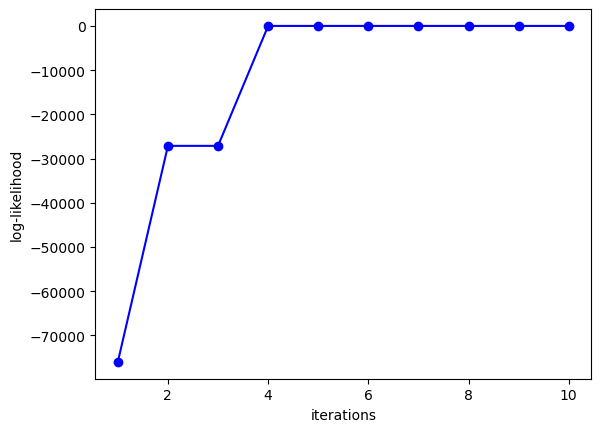

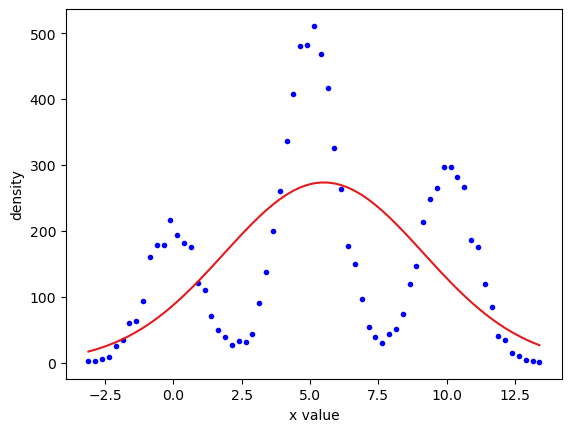

Initial Stats: logL=-244714.28, means=[3.74, 9.08], variances=[1, 1], weights=[0.5, 0.5]


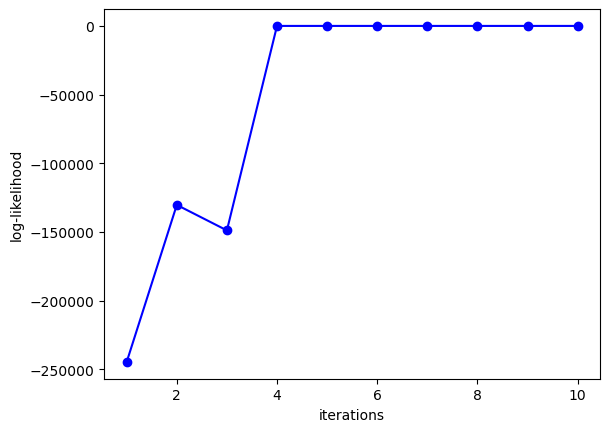

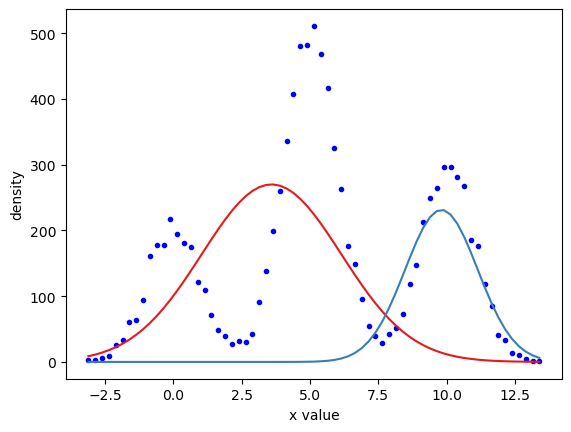

Initial Stats: logL=-949345.28, means=[-3.23, 5.26, 13.34], variances=[1, 1, 1], weights=[0.33, 0.33, 0.33]


/Users/vivian/sv_gmm/em.py:225: UserWarning: Maximum number of iterations reached without logL convergence
  # Convergence check


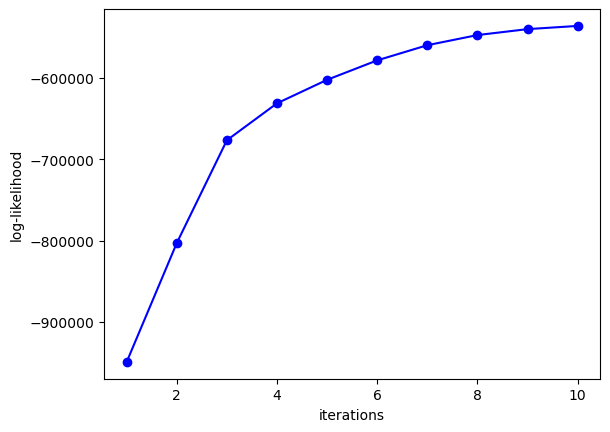

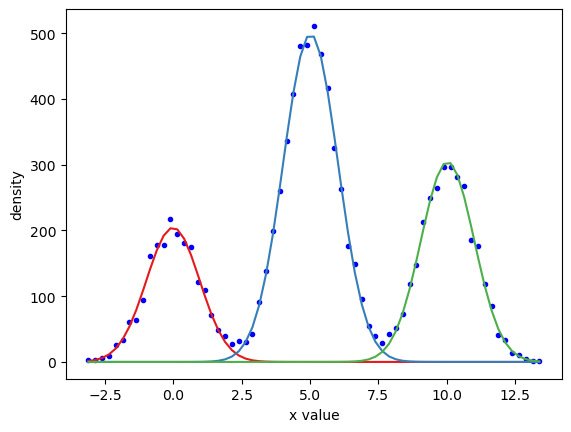

Number of SVs: 3
logL=-535795.41, means=[-0.01, 5.02, 10.03], variances=[0.95, 1.01, 0.96], weights=[0.2, 0.5, 0.3]


In [62]:
"""
2. Estimate the parameters via EM
"""

run_gmm(x)